Ett företag har fått in ett större parti av två typer färg. De har olika användningsområden men är mycket snarlika. Tyvärr har typerna blandats ihop i lagret och burkarna har ingen etikett. Ett mindre parti som ställdes undan vid avlastning har dock känd typ.

Vår uppgift är att, givet denna mindre kända mängd typer utveckla ett program som kan klassifiera en okänd färg genom att mäta luftfuktigheten och färgens avdunstning. Tanken är att testa många färger samtidigt-- den biten har de på golvet redan löst. Allt som saknas är en klassifikator.

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

df = pd.read_csv("../data/paint.csv")

df.head()


,Relative humidity (%),type,Evaporation (% wt)
0,35.3,1,11.2
1,29.6,1,11.0
2,31.0,1,12.6
3,58.0,1,8.3
4,62.0,1,10.1


Vi börjar med EDA. Bland de kända färgerna finns alltså två typer och deras avdunstning har testats vid olika luftfuktigheter.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Relative humidity (%)  31 non-null     float64
 1   type                   31 non-null     int64  
 2   Evaporation (% wt)     31 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 876.0 bytes


In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative humidity (%),31.0,52.470968,16.479972,28.0,37.2,56.0,70.0,77.0
type,31.0,0.516129,0.508001,0.0,0.0,1.0,1.0,1.0
Evaporation (% wt),31.0,8.022581,2.461667,4.0,6.0,8.0,9.3,13.0


Vi delar upp datan efter typ för att se om det verkligen finns en skillnad mellan de två.

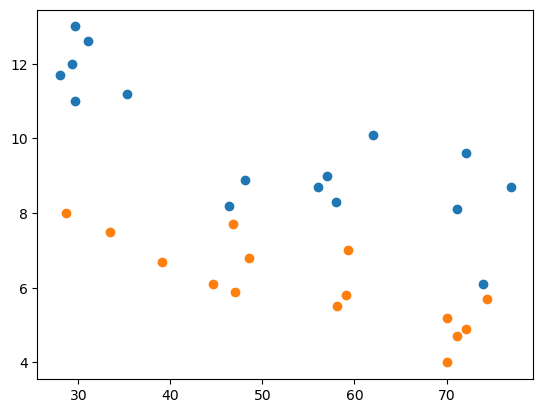

In [67]:
splitA = df[df["type"] == 1]
splitB = df[df["type"] == 0]
splitA, splitB
X_A = splitA["Relative humidity (%)"]
X_B = splitB["Relative humidity (%)"]
Y_A = splitA["Evaporation (% wt)"]
Y_B = splitB["Evaporation (% wt)"]
plt.scatter(X_A, Y_A)
plt.scatter(X_B, Y_B)

Ja, det ser ju definitivt ut som att datan kommer i två grupper. Vi prövar först med enkel linjär regression för att se "hur dåligt" det blir. 

Eftersom detta handlar om att reagera på okänd data är det väldigt viktigt att vi delar upp i tränings- och testdata. 

<AxesSubplot: xlabel='Relative humidity (%)', ylabel='Evaporation (% wt)'>

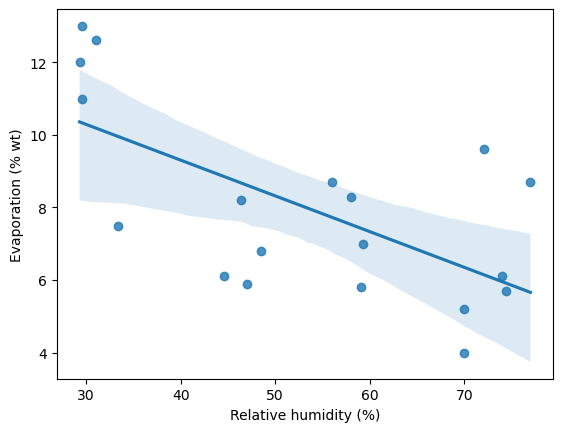

In [68]:
test = df.sample(frac=0.4, random_state=42, replace=False)
df = df.drop(test.index)

Y = df["Evaporation (% wt)"]

X = df["Relative humidity (%)"]

df.insert(0, "Intercept", 1)

sns.regplot(x = X, y = Y)

Inte så imponerande. Ganska många datapunkter hamnar utanför det skuggade konfidensintervallet.

Istället prövar vi med en multipel linjär regression med en indikatorvariabel för typ.

In [69]:
X = df.drop("Evaporation (% wt)", axis="columns")

In [70]:
b = np.linalg.inv(X.T @ X) @ X.T @ Y
b

0    10.523168
1    -0.080404
2     3.341150
dtype: float64

Hur bra blev det? Var det vettigt att inkludera typ? Det borde vara det, men hur motiverar vi det? Single variable predictor test!

Vi har en så begränsad mängd kända exempel att det är värt att räkna på statistiken, tex signifikanstest och förklaringsgrad.

In [71]:
X = X.to_numpy()
Y = Y.to_numpy()
v = len(b)-1
n = len(Y)
SSE = np.sum(np.square(Y - (X @ b)))
var = SSE/(n-v-1)
S = np.sqrt(var)

# Regression sum of squares, total variance
SSR = np.sum(b*(X.T @ Y)) - (np.square(np.sum(Y))/n)
Syy = np.sum(np.square(Y)) - (np.square(np.sum(Y))/n)

# Significant regression test, test rejects for large values
sig_statistic = (SSR/v)/var

# P score for H0 in significance test is very close to 0,
# -- we reject the hypothesis that no variable is relevant
p_sig = stats.f.sf(sig_statistic, v, n-v-1)

p_sig

8.061041681469357e-07

In [72]:
Rsq = SSR/Syy

Rsq

0.8268992714100364

In [73]:
c = np.linalg.inv(X.T @ X) * var

# Is there is no observer bias?
b2_statistic = b[2] / (S*np.sqrt(c[2, 2]))
# Two-sided test (rejects for large or small)
p_b2 = 2 * min(stats.t.cdf(b2_statistic, n-v-1), stats.t.sf(b2_statistic, n-v-1))
print(p_b2)

6.244978407925234e-05


Det gick ju fint. Det finns verkligen en typskillnad, vilket vi nu motiverat med statistik.

[[29.6]
 [31. ]
 [58. ]
 [72.1]
 [74. ]
 [77. ]
 [46.4]
 [29.6]
 [56. ]
 [29.3]
 [48.5]
 [59.3]
 [70. ]
 [70. ]
 [74.4]
 [44.6]
 [33.4]
 [59.1]
 [47. ]]


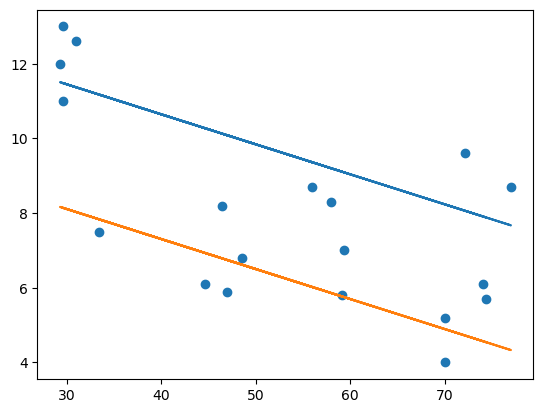

In [74]:
modA = np.append(b[0] + b[2], b[1:2])
modB = b[0:2]
Xr = X[:, 0:2]
print(Xr)
x = Xr[:, 1:2]
plt.scatter(x, Y)
plt.plot(x, Xr @ modA)
plt.plot(x, Xr @ modB)

print(x)

Låt oss nu köra test datan. Har vi lurat oss att det är bra, eller fungerar det med tidigare okänd data också?

Test A 0.15302312185196953 0.1480290389664886 0.38474542098183395
Test B 0.13025417901202663 0.08210218801792284 0.2865347937300509
Fel modell 1.068123410622088 3.694375885968244 1.922075931374264
Varians 1.3319873300880196


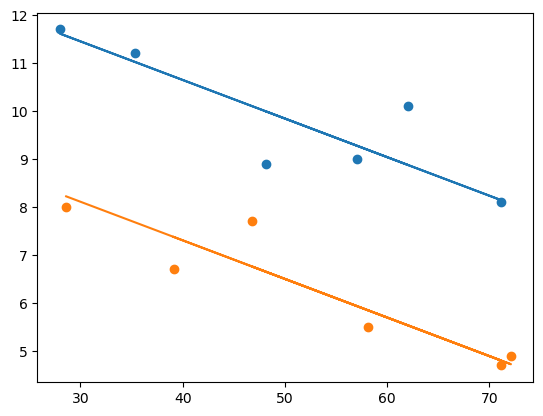

In [75]:
testA = test[test["type"] == 1]
x_test = testA["Relative humidity (%)"]
Y_test = testA["Evaporation (% wt)"]
testA = testA.drop(["type", "Evaporation (% wt)"], axis="columns")
testA.insert(0, "Intercept", 1)
X_test = testA.to_numpy()
plt.scatter(x_test, Y_test)
plt.plot(x_test, X_test @ modA)
MAE = 1 / n * np.sum(np.abs(Y_test - (X_test @ modA)))
MSE = 1 / n * np.sum((Y_test - (X_test @ modA)) ** 2)
RMSE = np.sqrt(MSE)


testB = test[test["type"] == 0]
x_test = testB["Relative humidity (%)"]
Y_test = testB["Evaporation (% wt)"]
testB = testB.drop(["type", "Evaporation (% wt)"], axis="columns")
testB.insert(0, "Intercept", 1)
X_test = testB.to_numpy()
plt.scatter(x_test, Y_test)
plt.plot(x_test, X_test @ modB)

MAEB = 1 / n * np.sum(np.abs(Y_test - (X_test @ modB)))
MSEB = 1 / n * np.sum((Y_test - (X_test @ modB)) ** 2)
RMSEB = np.sqrt(MSEB)
print("Test A", MAE, MSE, RMSE)
print("Test B", MAEB, MSEB, RMSEB)
print("Fel modell", 1 / n * np.sum(np.abs(Y_test - (X_test @ modA))),
      1 / n * np.sum((Y_test - (X_test @ modA)) ** 2), 
      np.sqrt(1 / n * np.sum((Y_test - (X_test @ modA)) ** 2)))
print("Varians", var)


Regressionen verkar gå bra, men nu skall vi ju klassifiera. Hur gör vi då? Jo, vi mäter helt enkelt luftfuktighet och avdunstning -- sedan förutsäger vi vad avdunstningen borde vara med vardera modell. Vi säger att det uppmätta värdet tillhör typen som gäller för den närmsta regressionslinjen (dvs de förutsagda värdena). Notera att vi kvadrerar avståndet för att överdriva större avstånd.

In [76]:

def classify(x, y):
    row_x = [1.0, x]
    ea_sq = np.square(y - np.dot(row_x, modA))
    eb_sq = np.square(y - np.dot(row_x, modB))
    return ea_sq < eb_sq

# classify
Y = test["Evaporation (% wt)"]
X = test["Relative humidity (%)"]
T = test["type"]
correct = True
for i, x in enumerate(X):
    correct &= T.iloc[i] == classify(x, Y.iloc[i])
print(f"Alla klassifikationer i test korrekta? {correct}")

Alla klassifikationer i test korrekta? True


Se där. Alla punkter i testdatan klassifierades korrekt. Inte illa för en så liten datamängd!